In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# importing the dataset and having a quick look
data = pd.read_csv("messy_trading_data.csv")

# getting a copy of the dataset to work on it safely
data_saved = data.copy()
data.head()

,Date,Price,Volume,Temperature,Day_Type
0,2022-01-01,52.483571,196.942732,22.980721,Weekend
1,2022-01-02,49.756010,189.759896,21.256343,Weekend
2,2022-01-03,54.133055,199.614946,22.324721,Weekday
3,2022-01-04,58.956939,225.802920,20.594690,Weekday
4,2022-01-05,50.618046,192.816402,19.400500,Weekday


In [3]:
# getting the data types of the labels
data.info()

# numerical check
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         367 non-null    object 
 1   Price        367 non-null    float64
 2   Volume       367 non-null    float64
 3   Temperature  362 non-null    float64
 4   Day_Type     367 non-null    object 
dtypes: float64(3), object(2)
memory usage: 14.5+ KB


,Price,Volume,Temperature
count,367.000000,367.000000,362.000000
mean,101.980788,455.799247,20.020354
std,54.759194,1233.995183,2.235571
min,-100.000000,-50.000000,13.407325
25%,83.897441,264.008819,18.530193
50%,99.964137,302.797166,19.928677
75%,116.796369,338.789924,21.616004
max,600.000000,10000.000000,26.729083


In [4]:
# temperature label seems an unwanted label in this case, so the column will be dropped for now
data = data.drop("Temperature", axis=1)

# date column should be converted to pandas date type so one can group by date easier
# additionally, I will use the date column as index
data['Date']= pd.to_datetime(data["Date"])
data = data.set_index("Date")

In [5]:
# checking the day_type column
data["Day_Type"].value_counts()

Day_Type
Weekday                  257
Weekend                  103
Holiday                    5
WhoAmI?                    1
WhyIsDataAlwaysMessy?      1
Name: count, dtype: int64

In [6]:
# Day_Type has some uncleaned data, they will be considered as non_weekday to keep any information
# also the column has encoded as categorical data so should be converted to dummy variables

dummy = pd.get_dummies(data["Day_Type"], dtype=int, prefix="is_")
dummy = dummy.iloc[:,1:2]
data = pd.concat((data, dummy), axis=1)
data = data.drop("Day_Type", axis=1)

In [7]:
# a quick look
data.head()

,Price,Volume,is__Weekday
Date,,,
2022-01-01,52.483571,196.942732,0
2022-01-02,49.756010,189.759896,0
2022-01-03,54.133055,199.614946,1
2022-01-04,58.956939,225.802920,1
2022-01-05,50.618046,192.816402,1


In [8]:
# lets check the null values (temperature label has been dropped)
print(data["Price"].isna().sum())
print(data["Volume"].isna().sum())

# price and volume numbers should be rounded 
data["Price"] = np.around(data["Price"].iloc[:],2)
data["Volume"] = np.around(data["Volume"].iloc[:],2)

0
0


<Figure size 2000x1000 with 0 Axes>

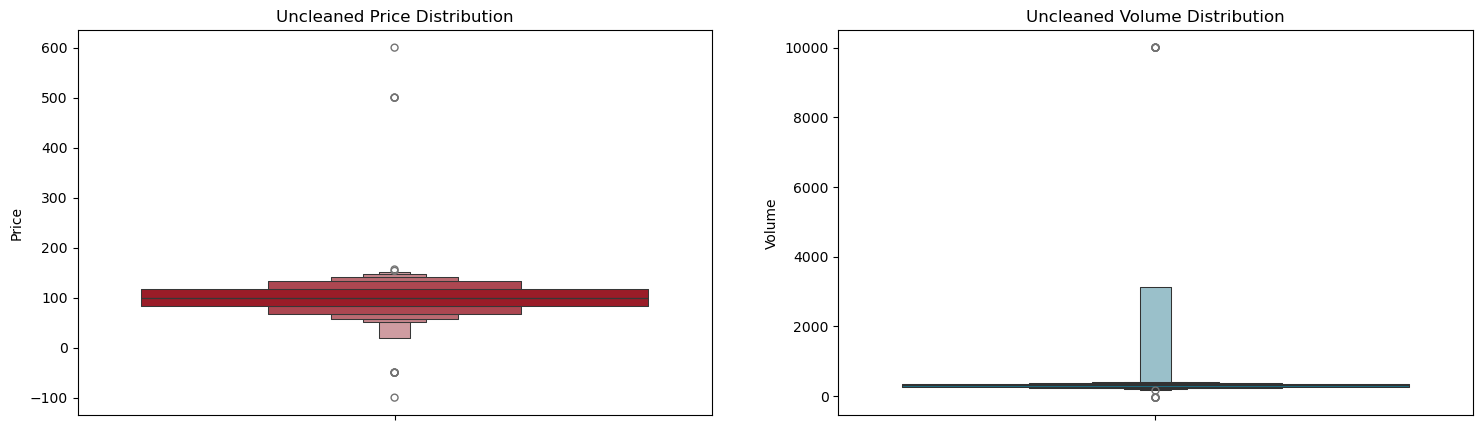

In [9]:
# checking the outliers and negative values
plt.figure(figsize=(20,10))
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxenplot(data = data["Price"], color= "#af0717", ax=axes[0]) 
axes[0].set_title('Uncleaned Price Distribution')

sns.boxenplot(data = data["Volume"], color= "#0681a0", ax=axes[1]) 
axes[1].set_title('Uncleaned Volume Distribution')
plt.xticks(rotation=90)
plt.show()

In [10]:
# the outliers will be trimmed by using the method interquartile range (IQR) for better analysis results 
# defining the math function

def iqr(column): 
    # function takes string as parameter
    
    q1 = np.quantile(data[column], 0.25)
    q3 = np.quantile(data[column], 0.75)
    diff = q3 - q1
    
    lower_t = q1 - (1.5 * diff)
    upper_t = q3 + (1.5 * diff)
    
    return (lower_t, upper_t)

In [11]:
# trimming process of the values
data = data[(data["Price"] < iqr("Price")[1]) & (data["Price"] > iqr("Price")[0])]
data = data[(data["Volume"] < iqr("Volume")[1]) & (data["Volume"] > iqr("Volume")[0])]

<Figure size 2000x1000 with 0 Axes>

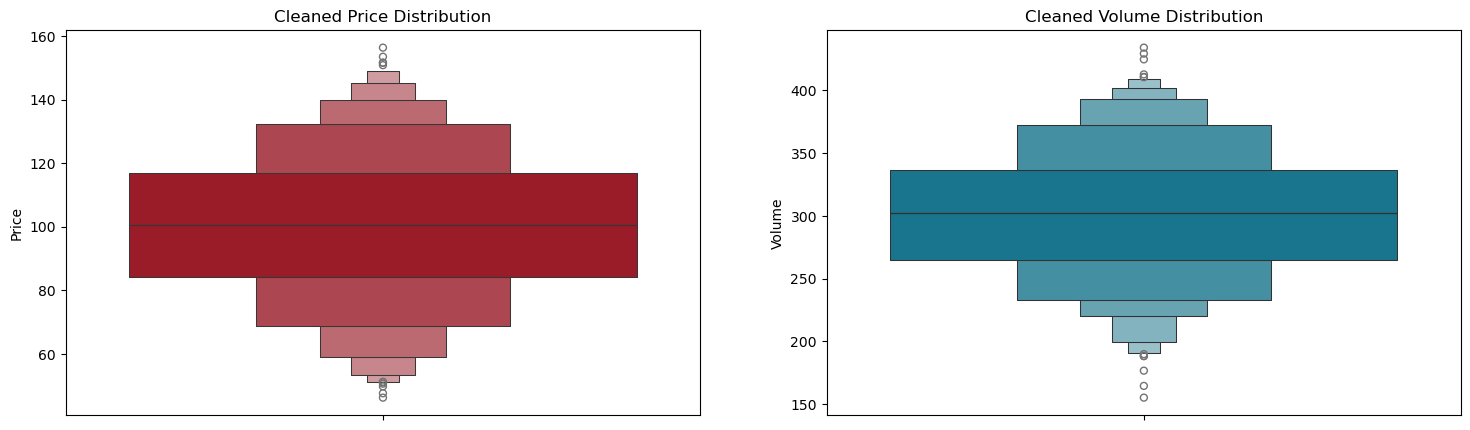

In [12]:
# checking the cleaned version

plt.figure(figsize=(20,10))
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxenplot(data = data["Price"], color= "#af0717", ax=axes[0]) 
axes[0].set_title('Cleaned Price Distribution')

sns.boxenplot(data = data["Volume"], color= "#0681a0", ax=axes[1]) 
axes[1].set_title('Cleaned Volume Distribution')
plt.xticks(rotation=90)
plt.show()

In [13]:
# 21 row dropped because of uncleaned or missing data
data.describe()

,Price,Volume,is__Weekday
count,346.000000,346.000000,346.000000
mean,100.074249,301.957659,0.699422
std,24.817506,55.136143,0.459173
min,46.230000,155.040000,0.000000
25%,84.135000,264.460000,0.000000
50%,100.670000,302.515000,1.000000
75%,116.812500,336.435000,1.000000
max,156.320000,434.150000,1.000000


In [14]:
# exporting the dataset and final look
data.to_csv("cleaned_trading_data", encoding='utf-8')
data.head()

,Price,Volume,is__Weekday
Date,,,
2022-01-01,52.48,196.94,0
2022-01-02,49.76,189.76,0
2022-01-03,54.13,199.61,1
2022-01-04,58.96,225.80,1
2022-01-05,50.62,192.82,1
